In [108]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import collections
import json
import glob
import math
import random
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline

### Apply the model to new data

In [2]:
# Read shapefiles
crs={'init':'epsg:4326'} # standard latitude, longitude coordinate system

# Boston subdistricts
bostonpoly = gpd.read_file("../Data_raw/Shapefiles/Boston_Neighborhoods/Boston_Neighborhoods.shp").to_crs(epsg=26986)
# Neighboring cities: Cambridge, Somerville, Brookline, Everett belong here
townpoly = gpd.read_file("../Data_raw/Shapefiles/towns/TOWNS_POLY.shp").to_crs(epsg=26986)
# MBTA metro routes
metroarc= gpd.read_file("../Data_raw/Shapefiles/mbta_rapid_transit/MBTA_ARC.shp")
# Fill in the water body (river, channel, sea) near the Greater Boston area
waterpoly = gpd.read_file("../Data_raw/Shapefiles/Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)


In [3]:
bostonpoly.head(3)

,OBJECTID,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen,geometry
0,27,Roslindale,1605.568237,15,2.51,6.993827e+07,53563.912597,(POLYGON ((230858.7079381704 891350.0335480083...
1,28,Jamaica Plain,2519.245394,11,3.94,1.097379e+08,56349.937161,"POLYGON ((232557.8810470573 897365.6609645427,..."
2,29,Mission Hill,350.853564,13,0.55,1.528312e+07,17918.724113,"POLYGON ((233752.6245367588 898445.2223148483,..."


In [191]:
bostonpoly.Neighborho=bostonpoly.Neighborho.astype(int)
mask_downtown=bostonpoly.Neighborho.isin([7,13,14,17,2,26,27,28,29,30,31,32,33,34])
mask_west=bostonpoly.Neighborho.isin([24, 25])
mask_east=bostonpoly.Neighborho.isin([4,8])
mask_south=bostonpoly.Neighborho.isin([10, 11, 12, 15, 16, 19, 6])

mask_neighbors=townpoly.TOWN_ID.isin([49, 93, 274])
mask_brookline=townpoly.TOWN_ID.isin([46])

In [192]:
townpoly[(townpoly.TOWN == "SOMERVILLE") | (townpoly.TOWN == "CAMBRIDGE")
        |(townpoly.TOWN == "BROOKLINE") | (townpoly.TOWN == "EVERETT")]

,OBJECTID,TOWN_ID,TOWN,FIPS_STCO,POP1980,POP1990,POP2000,POP2010,POPCH80_90,POPCH90_00,POPCH00_10,FOURCOLOR,TYPE,ISLAND,SHAPE_AREA,SHAPE_LEN,geometry
183,210,46,BROOKLINE,25021,53302,54718,57291,58732,1416,2573,1441,2,T,0,1.767328e+07,19105.786445,"POLYGON ((228292.3435999975 897804.6209000014,..."
320,351,49,CAMBRIDGE,25017,92535,95802,101355,105162,3267,5553,3807,3,C,0,1.855708e+07,26328.924307,"POLYGON ((228631.8435999975 905639.2509000003,..."
368,340,274,SOMERVILLE,25017,75836,76210,77478,75754,374,1268,-1724,4,C,0,1.071810e+07,19237.403195,"POLYGON ((230080.2836000025 906033.4409000017,..."
375,347,93,EVERETT,25017,36511,35701,38037,41667,-810,2336,3630,2,C,1,2.191214e+03,216.615194,"POLYGON ((235097.2236000001 906620.1209000014,..."
464,400,93,EVERETT,25017,36511,35701,38037,41667,-810,2336,3630,2,C,0,8.923108e+06,15290.935318,"POLYGON ((238842.183600001 908303.6209000014, ..."


In [201]:
## Create Polygons per zone
dtown=bostonpoly[mask_downtown].geometry.unary_union
west=bostonpoly[mask_west].geometry.unary_union
south=bostonpoly[mask_south].geometry.unary_union
east=bostonpoly[mask_east].geometry.unary_union
camb=townpoly[townpoly["TOWN"]=="CAMBRIDGE"].unary_union
some=townpoly[townpoly["TOWN"]=="SOMERVILLE"].unary_union
ever=townpoly[townpoly["TOWN"]=="EVERETT"].unary_union
west=west.union(townpoly[townpoly["TOWN"]=="BROOKLINE"].unary_union)


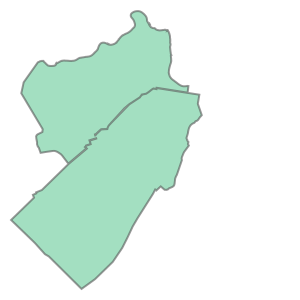

In [211]:
west

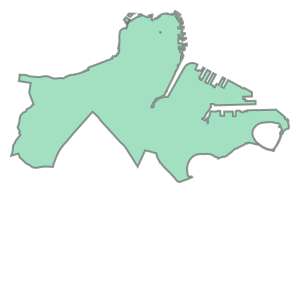

In [208]:
dtown

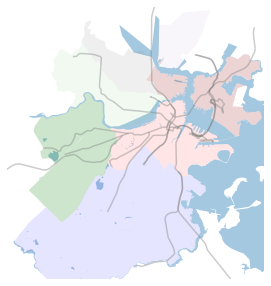

In [352]:
def default_mapbackground(fig, ax):
    ax.set_xlim([225000, 242500])
    ax.set_ylim([890000, 908500])
    metroarc.plot(ax=ax, alpha=0.4, color="grey")
    waterpoly.plot(ax=ax, alpha=0.4)
    plt.axis('off')

fig, ax=plt.subplots(figsize=(5,5))
default_mapbackground(fig, ax)

bostonpoly[mask_east].plot(color="brown",ax=ax, alpha=0.2)
bostonpoly[mask_west].plot(color="green",ax=ax, alpha=0.2)
bostonpoly[mask_downtown].plot(color="red",ax=ax, alpha=0.1)
bostonpoly[mask_south].plot(color="blue",ax=ax, alpha=0.1)
townpoly[mask_neighbors].plot(column="TOWN_ID", cmap="Accent",ax=ax, alpha=0.1)
townpoly[mask_brookline].plot(color="green",ax=ax, alpha=0.2)


In [78]:
# Read processed datasets
maindf=pd.read_csv("../Data_processed/maindf.csv", index_col=0)
hourly_empty_stations=pd.read_csv("../Data_processed/station_hours.csv", index_col=0)
MBTA_subway=pd.read_csv("../Data_processed/MBTA_subway.csv", index_col=0)

In [97]:
maindf.head(3)

,ID,Latitude,Longitude,Num_of_Docks,zip,zone,Num_Op_Months,Ave_Trips_Per_Month,Dist_to_Bikecenter,Min_Dist_Bikes_Sub,Num_Bikenodes_in_01,Monthly_Ave_Tripcount_01,Monthly_Ave_Tripcount_005,Red,Orange,Blue,GreenE,GreenD,GreenC,GreenB
0,3,42.340115,-71.100619,11,2115,0,25.0,523.48,0.017001,4.193608,15,11600.669483,1692.414545,0,0,0,1,0,0,0
1,4,42.345392,-71.069616,13,2116,0,25.0,900.04,0.016673,6.417015,25,18642.517307,1797.520000,0,1,0,0,0,0,0
2,5,42.341814,-71.090179,9,2115,0,20.0,883.65,0.008093,1.970203,12,14828.281016,2454.730000,0,0,0,1,0,0,0


### Create a dataframe which contains the center points of investigation for new bike stations

In [103]:
# Identify stations with low number of bikes
investigate=pd.merge(maindf[["ID", "Latitude", "Longitude", "Num_Bikenodes_in_01"]], 
                        hourly_empty_stations[["ID", "Station","mean", "median"]], 
                        how="left", left_on="ID", right_on="ID")
investigate=investigate[(investigate["median"] <=0.1) & (investigate["Num_Bikenodes_in_01"] <=10)].sort_values("mean")

In [105]:
investigate.describe()

,ID,Latitude,Longitude,Num_Bikenodes_in_01,mean,median
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,241.388889,42.359175,-71.082663,6.111111,0.096275,0.033848
std,110.942560,0.033858,0.041568,2.654383,0.045964,0.031978
min,65.000000,42.286307,-71.139613,3.000000,0.028509,0.000000
25%,153.750000,42.344804,-71.127007,4.000000,0.067460,0.000000
50%,212.000000,42.356496,-71.072953,5.500000,0.079200,0.050125
75%,360.500000,42.387200,-71.040913,8.500000,0.119990,0.058007
max,407.000000,42.407259,-71.028664,10.000000,0.192460,0.076923


In [106]:
add_investigate = pd.DataFrame({"ID":np.nan, "Latitude":Latitude, "Longitude":Longitude, 
                                "Num_Bikenodes_in_01":np.nan, "Station":Metro_station, "mean":np.nan, "median":np.nan})

In [107]:
investigate = pd.concat([investigate, add_investigate], sort=False, ignore_index=True)
investigate.tail(8)

,ID,Latitude,Longitude,Num_Bikenodes_in_01,Station,mean,median
16,136.0,42.344796,-71.031614,3.0,ID Building West,0.185185,0.000000
17,111.0,42.404490,-71.123413,7.0,Packard Ave at Powderhouse Blvd,0.192460,0.071429
18,NaN,42.408832,-71.118010,NaN,College Avenue,NaN,NaN
19,NaN,42.400512,-71.112001,NaN,Ball Square,NaN,NaN
20,NaN,42.393264,-71.106269,NaN,Magoon Square,NaN,NaN
21,NaN,42.384650,-71.097159,NaN,Gilman Square,NaN,NaN
22,NaN,42.380466,-71.087655,NaN,East Somerville,NaN,NaN
23,NaN,42.377396,-71.095169,NaN,Union Square,NaN,NaN


### Update MBTA subway with additional metro stations which are part of Green line Extension

In [85]:
MBTA_subway.tail(3)

,Metro_station,Latitude,Longitude,Red,Orange,Blue,GreenE,GreenD,GreenC,GreenB
110,Wonderland,42.413420,-70.991648,False,False,True,False,False,False,False
111,Woodland,42.333374,-71.244301,False,False,False,False,True,False,False
112,Warren Street,42.348343,-71.140457,False,False,False,False,False,False,True


In [86]:
Metro_station = ["College Avenue", "Ball Square", "Magoon Square", "Gilman Square", "East Somerville", "Union Square"]
Latitude = [42.408832, 42.400512, 42.393264,42.38465,42.380466,42.377396]
Longitude = [-71.118010, -71.112001,-71.106269,-71.097159,-71.087655,-71.095169]
add_Metro_stations = pd.DataFrame({"Metro_station": Metro_station, "Latitude": Latitude, "Longitude": Longitude, 
         "Red": False, "Orange": False, "Blue": False, "GreenE": True, "GreenD": True, "GreenC": True, "GreenB": True})
MBTA_subway_updated = pd.concat([MBTA_subway, add_Metro_stations], sort=False, ignore_index=True)
MBTA_subway_updated.tail(8)

,Metro_station,Latitude,Longitude,Red,Orange,Blue,GreenE,GreenD,GreenC,GreenB
111,Woodland,42.333374,-71.244301,False,False,False,False,True,False,False
112,Warren Street,42.348343,-71.140457,False,False,False,False,False,False,True
113,College Avenue,42.408832,-71.118010,False,False,False,True,True,True,True
114,Ball Square,42.400512,-71.112001,False,False,False,True,True,True,True
115,Magoon Square,42.393264,-71.106269,False,False,False,True,True,True,True
116,Gilman Square,42.384650,-71.097159,False,False,False,True,True,True,True
117,East Somerville,42.380466,-71.087655,False,False,False,True,True,True,True
118,Union Square,42.377396,-71.095169,False,False,False,True,True,True,True


### Create random points near the locations in the dataframe 'investigate'

In [401]:
random.seed(42)

In [402]:
nodes_bikes=np.array(list(zip(maindf.Latitude, maindf.Longitude)))
updated_nodes_subway= list(zip(MBTA_subway_updated.Latitude, MBTA_subway_updated.Longitude))

In [403]:
investigate_samples=pd.DataFrame()
for i in range(len(investigate)):
    a,b=investigate.iloc[i,[1,2]]
    xlist, ylist=[],[]
    
    #ten random samples within 008
    for j in range(10):
        r=random.uniform(0.002, 0.007)
        t=random.uniform(0, 2*math.pi)
        xlist.append(a+r*math.cos(t)), ylist.append(b+r*math.sin(t))

    test_nodes_bikes= np.array(list(zip(xlist, ylist)))
    
    testdf = pd.DataFrame({"Latitude": xlist,"Longitude": ylist})
    testdf["Dist_to_Bikecenter"] = cdist(test_nodes_bikes, [nodes_bikes[42]]) # nodes_bike42 is the center. See model_train.ipynb
    
    mindist_from_bikes_to_subway=np.min(cdist(test_nodes_bikes, updated_nodes_subway)*1000, axis=1)
    testdf["Min_Dist_Bikes_Sub"]=mindist_from_bikes_to_subway
    
    dist_from_bikes_to_bikes=cdist(test_nodes_bikes, nodes_bikes)
    # Number of bike stations within radius of 0.01 of each station
    testdf["Num_Bikenodes_in_01"]=(pd.DataFrame(dist_from_bikes_to_bikes)<0.01).sum(axis=1)
    
    tripcount_in_01=[]
    for i in range(len(test_nodes_bikes)):
        tripcount_in_01.append(maindf.Ave_Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.01].sum())                          
    testdf["Monthly_Ave_Tripcount_01"]=tripcount_in_01
    
    tripcount_in_005=[]
    for i in range(len(test_nodes_bikes)):
        tripcount_in_005.append(maindf.Ave_Trips_Per_Month[dist_from_bikes_to_bikes[i]<0.005].sum())                          
    testdf["Monthly_Ave_Tripcount_005"]=tripcount_in_005
    
    # The line name of nearest subway station
    nearest_subwayline=MBTA_subway_updated.iloc[np.argmin(cdist(test_nodes_bikes, updated_nodes_subway)*1000, axis=1)][["Red", "Orange", "Blue", "GreenE", "GreenD", "GreenC", "GreenB" ]]
    nearest_subwayline =nearest_subwayline.reset_index().drop("index", axis=1)
    testdf=pd.concat([testdf, nearest_subwayline.astype(int)], axis=1)
    
    geometry = [Point(xy) for xy in zip(testdf.Longitude, testdf.Latitude)] 
    testdf_geo=gpd.GeoDataFrame(testdf, crs=crs, geometry = geometry).to_crs(epsg=26986)

    for i in range(len(testdf_geo)):
        if testdf_geo.geometry.iloc[i].within(dtown):
            testdf_geo.loc[i,"zone"]=0
        elif testdf_geo.geometry.iloc[i].within(south):
            testdf_geo.loc[i,"zone"]=1
        elif testdf_geo.geometry.iloc[i].within(east):
            testdf_geo.loc[i,"zone"]=2
        elif testdf_geo.geometry.iloc[i].within(west):
            testdf_geo.loc[i,"zone"]=3
        elif testdf_geo.geometry.iloc[i].within(camb):
            testdf_geo.loc[i,"zone"]=4
        elif testdf_geo.geometry.iloc[i].within(some):
            testdf_geo.loc[i,"zone"]=5
        elif testdf_geo.geometry.iloc[i].within(ever):
            testdf_geo.loc[i,"zone"]=6
        else:
            testdf_geo.loc[i,"zone"]=np.nan
    
    investigate_samples= pd.concat([investigate_samples,testdf_geo], sort=False)

In [404]:
investigate_samples=investigate_samples.dropna()

In [405]:
investigate_samples= investigate_samples[['Latitude', 'Longitude', 'zone', 'Dist_to_Bikecenter',
       'Min_Dist_Bikes_Sub', 'Num_Bikenodes_in_01', 'Monthly_Ave_Tripcount_01',
       'Monthly_Ave_Tripcount_005', 'Red', 'Orange', 'Blue', 'GreenE',
       'GreenD', 'GreenC', 'GreenB',"geometry"]]

In [ ]:
# plot investigate, investigate samples 

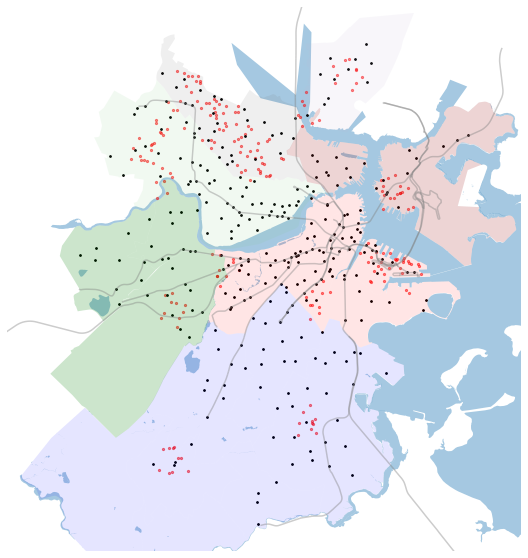

In [406]:
fig, ax=plt.subplots(figsize=(10,10))
default_mapbackground(fig, ax)
investigate_samples.plot(color="red",ax=ax, markersize=5, alpha=0.5)
geometry=[Point(xy) for xy in zip(maindf.Longitude, maindf.Latitude)]
maindf_geo=gpd.GeoDataFrame(maindf, crs=crs, geometry = geometry).to_crs(epsg=26986)
maindf_geo.plot(ax=ax,color="black", markersize=3)

bostonpoly[mask_east].plot(color="brown",ax=ax, alpha=0.2)
bostonpoly[mask_west].plot(color="green",ax=ax, alpha=0.2)
bostonpoly[mask_downtown].plot(color="red",ax=ax, alpha=0.1)
bostonpoly[mask_south].plot(color="blue",ax=ax, alpha=0.1)
townpoly[mask_neighbors].plot(column="TOWN_ID", cmap="Accent",ax=ax, alpha=0.1)
townpoly[mask_brookline].plot(color="green",ax=ax, alpha=0.2)

### Apply the model to the test points and recommend three new locations per zone

In [246]:
%store -r X
%store -r y

In [407]:
X_investigate=investigate_samples.drop("geometry", axis=1)

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
GBregr = GradientBoostingRegressor(n_estimators=100, max_depth=2)
GBregr.fit(X_train, np.log(y_train))

print("train score:",GBregr.score(X_train, np.log(y_train)))
print("test score:", GBregr.score(X_test, np.log(y_test)))
print("mean validation score:",(cross_validate(GBregr, X_train, np.log(y_train), cv=5)["test_score"]).mean())

train score: 0.9414150980786412
test score: 0.8172928457606393
mean validation score: 0.7642089876077705


In [409]:
y_investigate_predict=np.exp(GBregr.predict(X_investigate))
investigate_samples["Ave_volume_prediction"] = y_investigate_predict

In [413]:
# Find the locations where the bike station density is not too high 
recommend=investigate_samples[investigate_samples.Num_Bikenodes_in_01 <10][["Latitude", "Longitude", "zone", "Num_Bikenodes_in_01", "Ave_volume_prediction", "geometry"]]

# Sort by the volume prediction in the descending order
recommend=recommend.sort_values("Ave_volume_prediction", ascending=False)

# Drop duplicates to remove any locations that are "too close", essentially predicting the same location multiple times
recommend=recommend.drop_duplicates(subset="Ave_volume_prediction", keep='first', inplace=False)

# Pick top three locations per zone satisfying all the crietria above
recommend=recommend.groupby("zone").head(3).sort_values("zone")

In [414]:
recommend

,Latitude,Longitude,zone,Num_Bikenodes_in_01,Ave_volume_prediction,geometry
4,42.350287,-71.108508,0.0,9,552.567575,POINT (232255.7527969752 900050.736210533)
6,42.345847,-71.042076,0.0,9,543.195187,POINT (237731.8310224084 899584.8184507651)
0,42.335048,-71.070672,0.0,9,542.370919,POINT (235381.6076279192 898373.0174208924)
6,42.302239,-71.074751,1.0,5,50.216357,POINT (235063.6341511772 894727.1368138285)
4,42.295745,-71.069571,1.0,6,65.745949,POINT (235494.4305812646 894007.8913372564)
8,42.283912,-71.129037,1.0,3,59.171476,POINT (230596.3862065105 892670.6149924386)
7,42.364128,-71.041251,2.0,6,144.195479,POINT (237788.8402388103 901615.7245580673)
2,42.373216,-71.041920,2.0,5,203.304481,POINT (237728.3221571953 902624.8442389688)
0,42.389750,-71.074503,2.0,5,222.018442,POINT (235035.5981948108 904447.4680551388)
0,42.345821,-71.109310,3.0,7,540.038364,POINT (232192.0033732228 899554.3152138086)


In [417]:
recommend.to_csv("../Data_processed/recommend.csv")

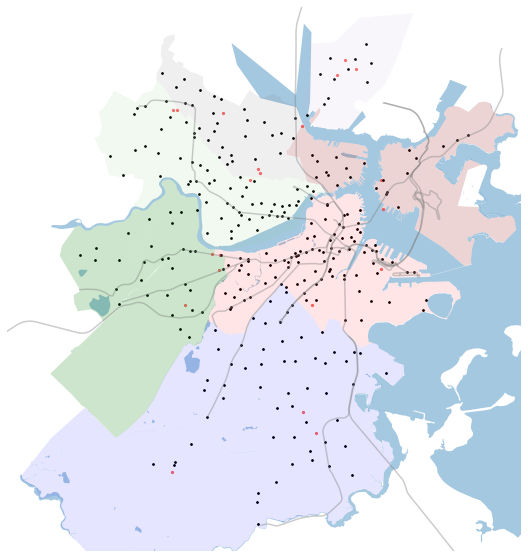

In [415]:
fig, ax=plt.subplots(figsize=(10,10))
default_mapbackground(fig, ax)
#investigate_samples.plot(color="red",ax=ax, markersize=5, alpha=0.5)
recommend.plot(color="red",ax=ax, markersize=5, alpha=0.5)
geometry=[Point(xy) for xy in zip(maindf.Longitude, maindf.Latitude)]
maindf_geo=gpd.GeoDataFrame(maindf, crs=crs, geometry = geometry).to_crs(epsg=26986)
maindf_geo.plot(ax=ax,color="black", markersize=3)

bostonpoly[mask_east].plot(color="brown",ax=ax, alpha=0.2)
bostonpoly[mask_west].plot(color="green",ax=ax, alpha=0.2)
bostonpoly[mask_downtown].plot(color="red",ax=ax, alpha=0.1)
bostonpoly[mask_south].plot(color="blue",ax=ax, alpha=0.1)
townpoly[mask_neighbors].plot(column="TOWN_ID", cmap="Accent",ax=ax, alpha=0.1)
townpoly[mask_brookline].plot(color="green",ax=ax, alpha=0.2)